In [1]:
import requests
import urllib
import re
import tqdm
from PIL import Image
from io import BytesIO
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.animation as animation
from keras.engine.topology import Layer, InputSpec
import keras.utils.conv_utils as conv_utils
import keras.backend as K
import cv2
from Keras_CoordConv.coord import CoordinateChannel2D

Using TensorFlow backend.


In [2]:
def saveimages():
    ans=requests.get('https://3dtor.net')
    references=[]
    ans=requests.get('https://3dtor.net')
    filmre=re.compile("a href=\"https://3dtor.net/film_3d/.*html")
    multre=re.compile("a href=\"https://3dtor.net/mult_3d/.*html")
    references=references+re.findall(multre,ans.text)+re.findall(filmre,ans.text)
    for i in tqdm.tqdm(range(1,128,1)):
        ans=requests.get('https://3dtor.net/page/{}/'.format(i))
        references=references+re.findall(multre,ans.text)+re.findall(filmre,ans.text)
    references=list(set(references))
    imageurls=[]
    for reference in tqdm.tqdm(references):
        ans=requests.get(reference[8:])
        imageurls=imageurls+[obj[6:-2] for obj in re.findall("href=\"https://i.*?[\s]",ans.text)]
    def prepr(url):
        if url[-3:]=='png':
            return url
        if url[-3:]=='jpg':
            return url
        return url[:-5]
    betterurls=[prepr(url) for url in imageurls]
    '''for i, imageurl in tqdm.tqdm(enumerate(betterurls[:])):
        response = requests.get(imageurl)
        im=Image.open(BytesIO(response.content))
        im = im.convert("RGB")
        im.save('frames/{}'.format(i)+'.jpg')'''
    return 0

In [ ]:
vidcap = cv2.VideoCapture('Godzilla.KingOfTheMonsters(2019)3D-hOU(Ash61).mkv')
success,image = vidcap.read()
count = 0
ctr=0
while success:
    #cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
    success,image = vidcap.read()
    count += 1
    ctr=ctr+1
    if ctr==200:
        print('Write a new frame: ', count//200)
        U=image[:image.shape[0]//2,:,:][:,:,::-1]
        D=image[image.shape[0]//2:,:,:][:,:,::-1]
        U=Image.fromarray(U)
        D=Image.fromarray(D)
        U.resize((U.size[0],U.size[1]*2)).save("Uf/Longday"+str(count//200)+'.jpg')
        D.resize((D.size[0],D.size[1]*2)).save("Df/Longday"+str(count//200)+'.jpg')
        ctr=0

In [3]:
def convertvideo(videoname, modelconverter):
    vidcap = cv2.VideoCapture(videoname)
    success,image = vidcap.read()
    #out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc('M','J','P','G'), 24 (320,320))
    #return image
    #out=cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 24, (320,320))
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    #fourcc=cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('BTFu3D.mp4', fourcc, 24.0, (320,640))
    count = 0
    ctr=0
    while success:
        #cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
        try:
            success,image = vidcap.read()
            count += 1
            ctr=ctr+1
            imageU=tf.image.resize_with_crop_or_pad(image, np.max(image.shape),np.max(image.shape))
            U=tf.image.resize(imageU,(320,320),method='nearest')
            CC=np.expand_dims(np.transpose(np.indices((U.shape[0],U.shape[1]))/U.shape[0],(1,2,0)),0)
            D=modelconverter.predict([np.stack([U/255]), CC])[0,:,:,:].clip(0,1)
            #D=0
            #D=D.astype(int)
            #return U,D
            #U=np.ones(U.shape)
            frame=np.concatenate([U,D*255],0)
            frame = cv2.resize(frame,(320,640))
            frame=frame.astype(dtype=np.uint8)
            #return frame
            out.write(frame)
            #print (ctr)
            if ctr%(24*60)==0:
                print (ctr//(24*60),'  min')
        except:
            break
        #    break
    vidcap.release()
    out.release()
    return frame

In [ ]:
frame=convertvideo('Back to the Future.avi',downfromup)

In [ ]:
cv2.imshow('frame',frame)
cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
frame.shape

In [ ]:
plt.imshow(frame)

In [4]:
def dividetoupdown():
    for imagepath in tqdm.tqdm(os.listdir('frames')):
        im=Image.open('frames/'+imagepath)
        npim=np.array(im.resize((im.size[0],im.size[1]*2)))
        U=npim[:npim.shape[0]//2,:,:]
        D=npim[npim.shape[0]//2:,:,:]
        Image.fromarray(U).save("Up/"+imagepath)
        Image.fromarray(D).save("Down/"+imagepath)
    return 0

In [5]:
class BilinearUpSampling2D(Layer):
    def __init__(self, size=(2, 2), data_format=None, **kwargs):
        super(BilinearUpSampling2D, self).__init__(**kwargs)
        self.data_format = K.normalize_data_format(data_format)
        self.size = conv_utils.normalize_tuple(size, 2, 'size')
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
            return (input_shape[0],
                    input_shape[1],
                    height,
                    width)
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
            return (input_shape[0],
                    height,
                    width,
                    input_shape[3])

    def call(self, inputs):
        input_shape = K.shape(inputs)
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
        return tf.image.resize(inputs, [height, width], method=tf.image.ResizeMethod.BILINEAR)

    def get_config(self):
        config = {'size': self.size, 'data_format': self.data_format}
        base_config = super(BilinearUpSampling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
def ssim_loss(y_true, y_pred):
    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1)) * 0.5, 0, 1)
    return l_ssim+tf.keras.losses.MAE(y_true, y_pred)

In [6]:
def depth_loss_function(y_true, y_pred, theta=0.1, maxDepthVal=1000.0/10.0):
    
    # Point-wise depth
    l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)

    # Edges
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    # Structural similarity (SSIM) index
    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, maxDepthVal)) * 0.5, 0, 1)

    # Weights
    w1 = 1.0
    w2 = 1.0
    w3 = theta

    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))


In [7]:
def animate(U,D, savename='test',show=False):
    ims=[]
    fig = plt.figure()
    for i in range(10):
        if i%2==0:
            im = plt.imshow(U, animated=True)
            plt.axis('off')
        else:
            im = plt.imshow(D, animated=True)
            plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                    repeat_delay=10)
    ani.save('gifs/'+savename+'.gif', writer='imagemagick', fps=10)
    if show:
        plt.show()
    return 0

In [8]:
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': depth_loss_function,'ssim_loss':ssim_loss}

In [9]:
modeldepth=tf.keras.models.load_model('nyu.h5',custom_objects=custom_objects)
for layer in modeldepth.layers:
    layer.trainable=False
#modeldepth.compile(optimizer= 'Adam', loss='mse')

In [20]:
for layer in modeldepth.layers:
    layer.trainable=True

In [10]:
def load(image_file, Upath='Uf', Dpath='Df'):
    imageU = tf.io.read_file(Upath+'/'+image_file)
    imageU = tf.image.decode_jpeg(imageU)
    imageU=tf.image.resize_with_crop_or_pad(imageU, np.max(imageU.shape),np.max(imageU.shape))
    imageU=tf.image.resize(imageU,(320,320))

    imageD = tf.io.read_file(Dpath+'/'+image_file)
    imageD = tf.image.decode_jpeg(imageD)
    imageD=tf.image.resize_with_crop_or_pad(imageD, np.max(imageD.shape),np.max(imageD.shape))
    imageD=tf.image.resize(imageD,(imageU.shape[0],imageU.shape[0]))

    imageU = tf.cast(imageU, tf.float32)
    imageD = tf.cast(imageD, tf.float32)
    imageUxcoord=np.expand_dims(np.transpose(np.indices((imageU.shape[0],imageU.shape[1]))/imageU.shape[0],(1,2,0)),0)
    imageU=tf.expand_dims(imageU,0).numpy()/255
    return [imageU,imageUxcoord], tf.expand_dims(imageD,0).numpy()/255
def datagen(Upath,Dpath, batchsize=1):
    listofnames=os.listdir(Upath)
    random.shuffle(listofnames)
    while True:
        for i in range(len(listofnames)):
            yield load(listofnames[i],Upath,Dpath)


In [11]:
inp=tf.keras.layers.Input((None,None,3))
#fixed_input = tf.keras.layers.Input((None,None,3))
depthmap=modeldepth(inp)
coordchannel=tf.keras.layers.Input((None,None,2))
depthmap=tf.keras.layers.UpSampling2D(size=(2, 2))(depthmap)
depthmap=depthmap/10
#depthmap=CoordinateChannel2D()(depthmap)

#COORDCONV LAYER IMPLEMENTATION

# concecatentate to get image-coordinput-depth
x=tf.keras.layers.Concatenate()([inp, depthmap,coordchannel])
x0=tf.keras.layers.Conv2D(64,7,padding='same')(x)
x=x0
for i in range(4):
    y=tf.keras.layers.Conv2D(64,3,activation='relu',padding='same')(x)
    y=tf.keras.layers.Conv2D(64,3,padding='same')(y)
    x=tf.keras.layers.Add()([x,y])
x=tf.keras.layers.Conv2D(64,3,padding='same')(x)
x=tf.keras.layers.Add()([x0,x])
out=tf.keras.layers.Conv2D(3,3,padding='same')(x)
#out=tf.keras.layers.Conv2D(48,3,padding='same')(x)
#out=tf.keras.layers.Lambda (lambda z: tf.nn.depth_to_space(z, 4))(x)
downfromup=tf.keras.models.Model(inputs=[inp,coordchannel], outputs=out)
#downfromup.compile(loss='mse',optimizer='Adam')
downfromup.compile(loss=ssim_loss,optimizer=tf.keras.optimizers.Adam(lr=0.0001))

In [ ]:
downfromup.summary()

In [ ]:
downfromup=tf.keras.models.load_model('downfromup_unfreezed_СС_val0.09941591322422028.h5',custom_objects=custom_objects)
for layer in downfromup.layers[1].layers:
    layer.trainable=True


In [24]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint_fulltrain_cc_{epoch:02d}-{val_loss:.2f}.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [23]:
downfromup.compile(loss=ssim_loss,optimizer=tf.keras.optimizers.Adam(lr=0.0001))

In [12]:
genertest=datagen('Up','Down')

In [ ]:
gener=datagen('Uf','Df')
hist=downfromup.fit(gener,epochs=10,steps_per_epoch=len(os.listdir('Uf')),validation_data=genertest, validation_steps=len(os.listdir('Up')),callbacks=[model_checkpoint_callback])


Epoch 1/10
4112/4112 [==============================] - 1360s 331ms/step - loss: 0.0534 - val_loss: 0.0944
Epoch 2/10
4112/4112 [==============================] - 1362s 331ms/step - loss: 0.0510 - val_loss: 0.0936
Epoch 3/10
4112/4112 [==============================] - 1363s 331ms/step - loss: 0.0485 - val_loss: 0.0951
Epoch 4/10
4112/4112 [==============================] - 1370s 333ms/step - loss: 0.0471 - val_loss: 0.0954
Epoch 5/10
4112/4112 [==============================] - 1368s 333ms/step - loss: 0.0450 - val_loss: 0.0956
Epoch 6/10
2580/4112 [=================>............] - ETA: 7:49 - loss: 0.0439

In [ ]:
plt.plot(hist.history['loss'])

In [15]:
A=next(genertest)

U=A[0][0][0,:,:,:]
Dp=downfromup.predict(A[0])[0,:,:,:].clip(0,1)
D=A[1][0,:,:,:]
'''
plt.figure(figsize=(10,10))
plt.subplot(2,2,2)
plt.imshow(U)
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(D)
plt.axis('off')
plt.subplot(2,2,1)
plt.imshow(Dp)
plt.axis('off')'''

"\nplt.figure(figsize=(10,10))\nplt.subplot(2,2,2)\nplt.imshow(U)\nplt.axis('off')\nplt.subplot(2,2,3)\nplt.imshow(D)\nplt.axis('off')\nplt.subplot(2,2,1)\nplt.imshow(Dp)\nplt.axis('off')"

In [16]:
%matplotlib inline

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
MovieWriter imagemagick unavailable; trying to use <class 'matpl

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
C:\Users\anona\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
C:\Users\anona\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykerne

C:\Users\anona\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
C:\Users\anona\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
MovieWriter imagemagick unavailable; trying to use <class 

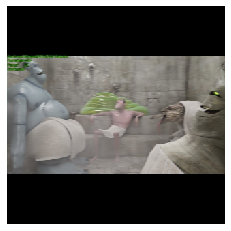

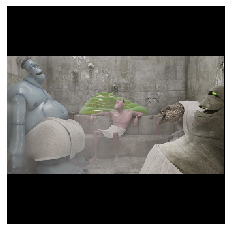

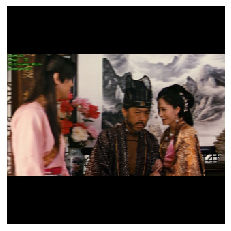

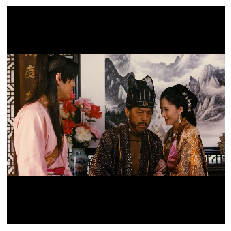

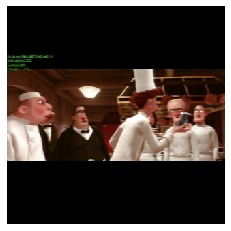

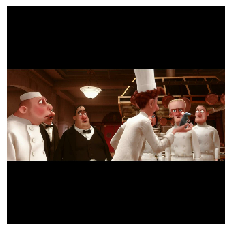

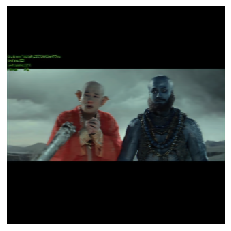

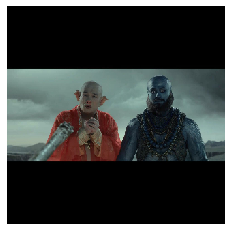

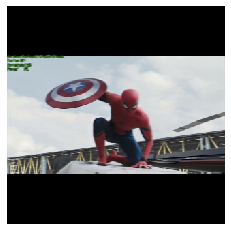

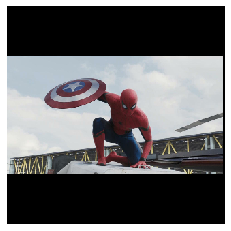

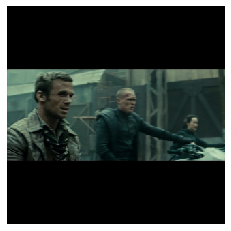

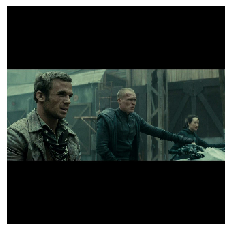

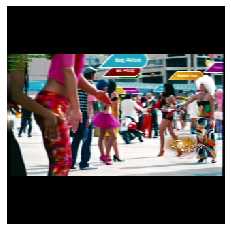

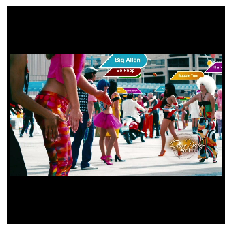

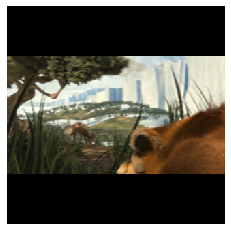

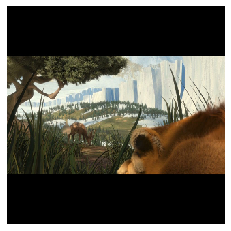

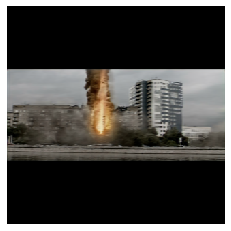

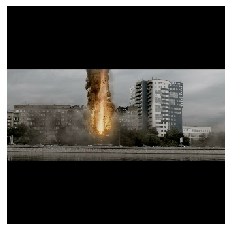

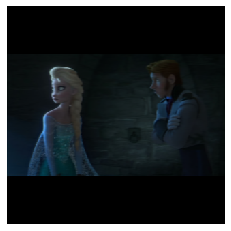

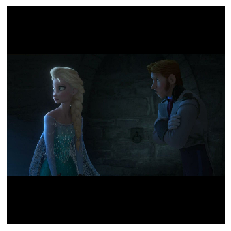

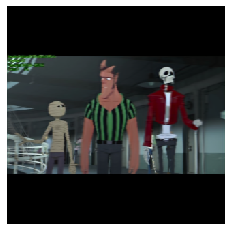

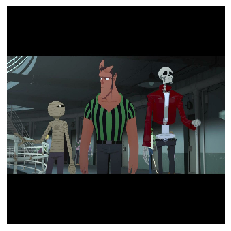

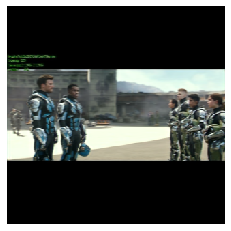

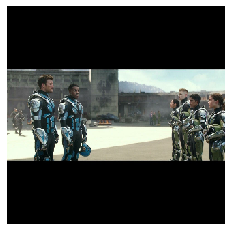

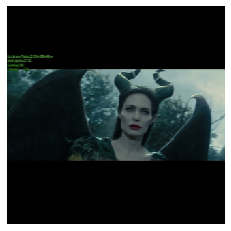

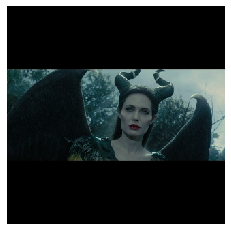

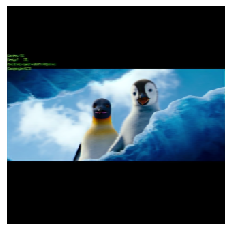

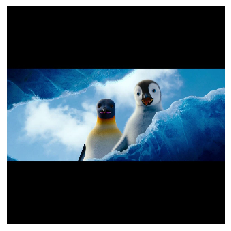

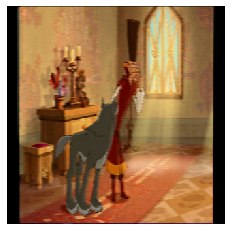

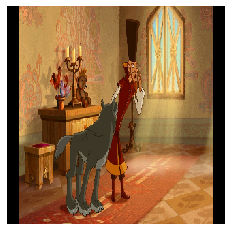

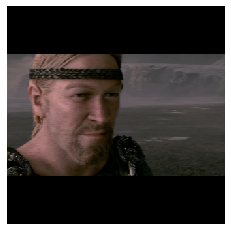

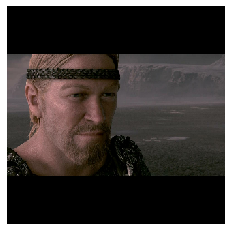

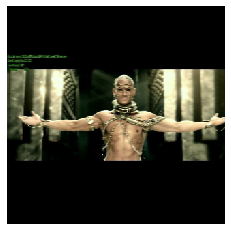

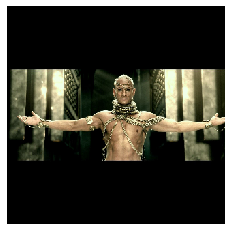

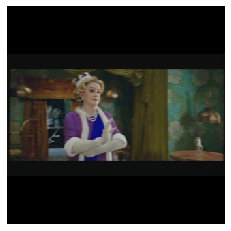

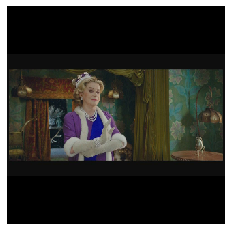

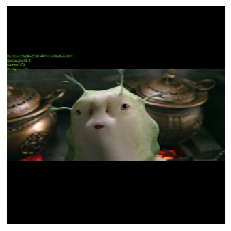

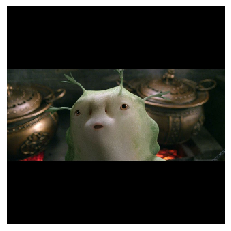

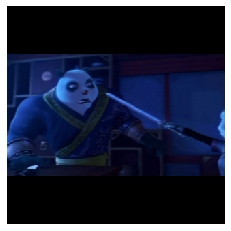

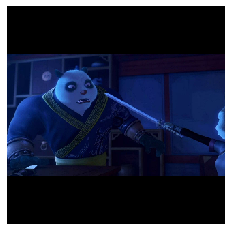

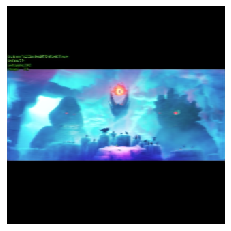

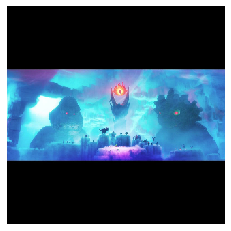

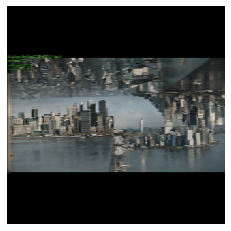

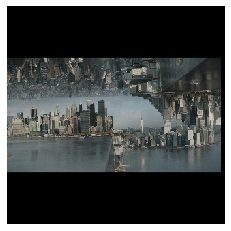

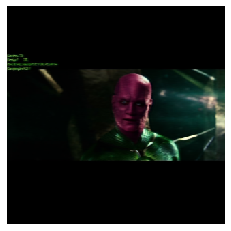

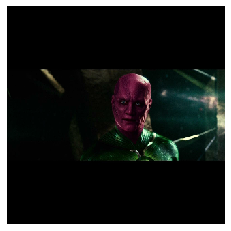

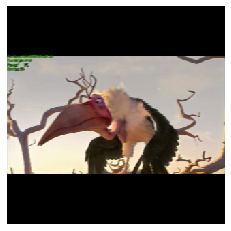

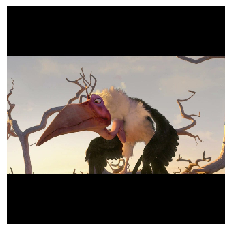

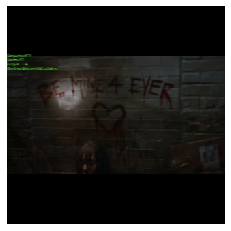

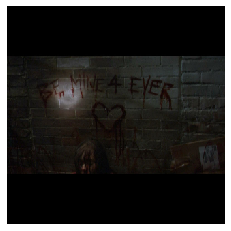

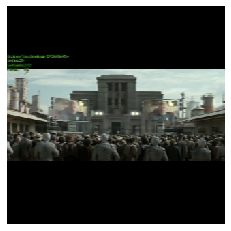

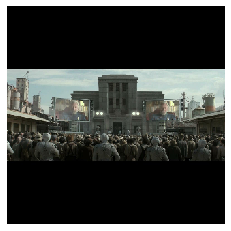

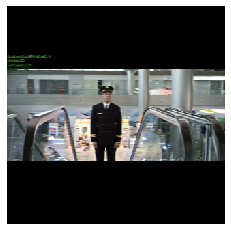

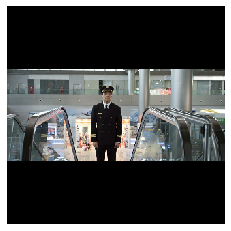

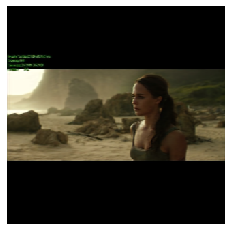

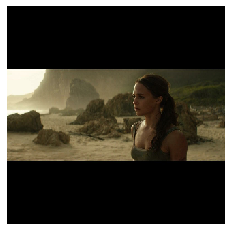

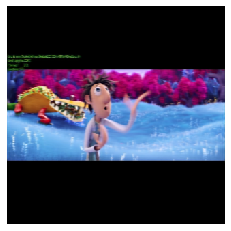

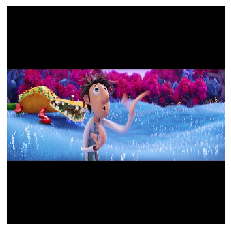

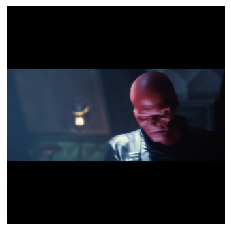

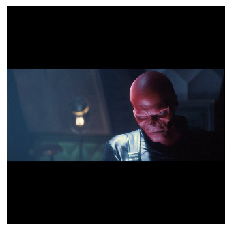

In [19]:
for i in range (30):
    A=next(genertest)
    U=A[0][0][0,:,:,:]
    Dp=downfromup.predict(A[0])[0,:,:,:].clip(0,1)
    D=A[1][0,:,:,:]
    animate (U, Dp,'generated{}'.format(i))
    animate (U, D,'/real/real{}'.format(i))

In [ ]:
plt.figure(1)
plt.imshow(U-Dp)
plt.figure(2)
plt.imshow(U-D)